In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir ="/content/drive/MyDrive/plant/train/"
test_dir="/content/drive/MyDrive/plant/test/"

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [ ]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) 
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

6 Classes
490 Train images
21 Test images


In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_dir, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 489 images belonging to 6 classes.
Found 21 images belonging to 3 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'Bacterial_Spot': 0, 'Early_Blight': 1, 'Healthy': 2}
{0: 'Bacterial_Spot', 1: 'Early_Blight', 2: 'Healthy'}


In [ ]:
import random
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_dir)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_dir)):
        image_ids = os.listdir(os.path.join(train_dir,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(train_dir,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

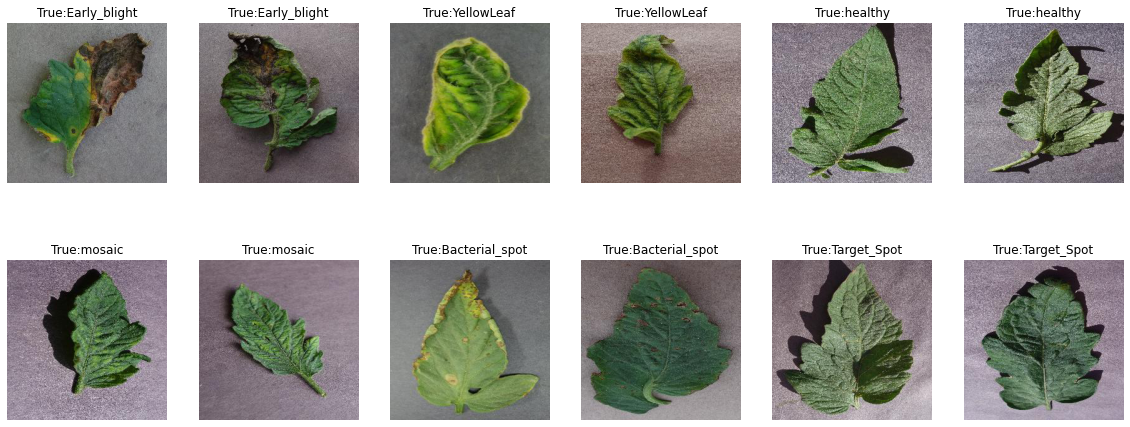

In [ ]:
import numpy as np

show_few_images(2)

In [ ]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 60
vgg_epoch = 60
resnet_epoch = 60
inception_epoch = 60



In [ ]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(6,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 128)     18944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7

In [ ]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')


Epoch 1/60
16/16 [==============================] - ETA: 0s - loss: 2.4439 - acc: 0.2025

InvalidArgumentError: ignored

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(6,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')


Epoch 1/60
16/16 [==============================] - ETA: 0s - loss: 6.0217 - acc: 0.4172 

InvalidArgumentError: ignored

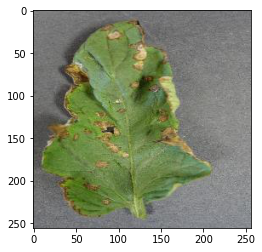

In [ ]:
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('/content/drive/MyDrive/plant/train/Bacterial_spot/f248467c-ef23-484b-99d3-019559f58f4d___UF.GRC_BS_Lab Leaf 0407.JPG')
plt.imshow(img1);
img1 = image.load_img('/content/drive/MyDrive/plant/train/Early_blight/cf2919ca-2b62-4f23-8a55-5dfa953db83c___RS_Erly.B 7352.JPG', target_size=(256, 256))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [ ]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [ ]:
y_pred = model.predict()

In [ ]:
y_pred

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_resnet50.h5')

In [ ]:
img=image.load_img('#Path of the test image',target_size=(224,224))

In [ ]:
x=image.img_to_array(img)
x

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

In [ ]:
model.predict(img)

In [ ]:
a=np.argmax(model.predict(img), axis=1)

In [ ]:
a == 1  